# Lab 2: Clustering

The goal of this lab session is to code a clustering algorithm, apply it to data and compare the performance with other techniques.

You have to send the filled notebook named **"L2_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com by October 9, 2019. Please put **"AML-L2"** in the subject. 

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster # all clustering techniques except hdbscan
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

We will have two toy datasets to try the different methods:

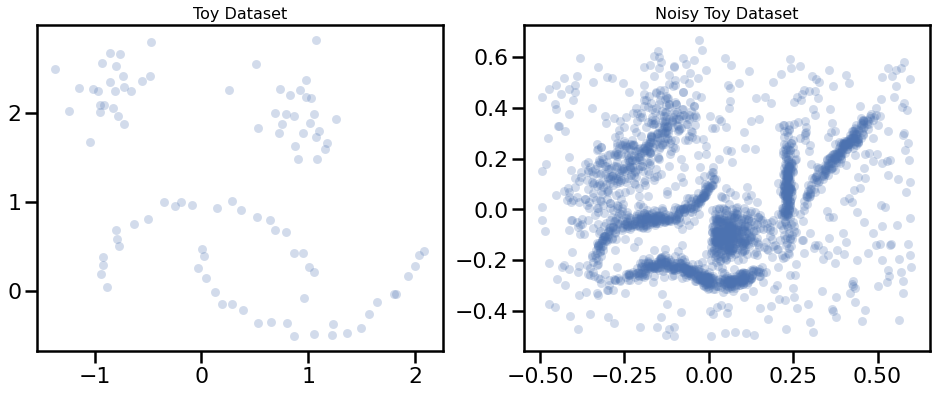

In [4]:
import sklearn.datasets as data
moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data_0 = np.vstack([moons, blobs])

test_data_1 = np.load('clusterable_data.npy')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c='b', **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], color='b', **plot_kwds)
ax[1].set_title('Noisy Toy Dataset', size=16)

plt.show();

There are a lot of clustering algorithms to choose from the `sklearn` library. So what clustering algorithms should you be using? It depends.

## K-means

K-Means is the 'go-to' clustering algorithm for many simply because it is fast, easy to understand, and available everywhere (there's an implementation in almost any statistical or machine learning tool you care to use). However, K-Means has a few problems caused by its simplicity. 

We try the `sklearn` implementation in our toy datasets:

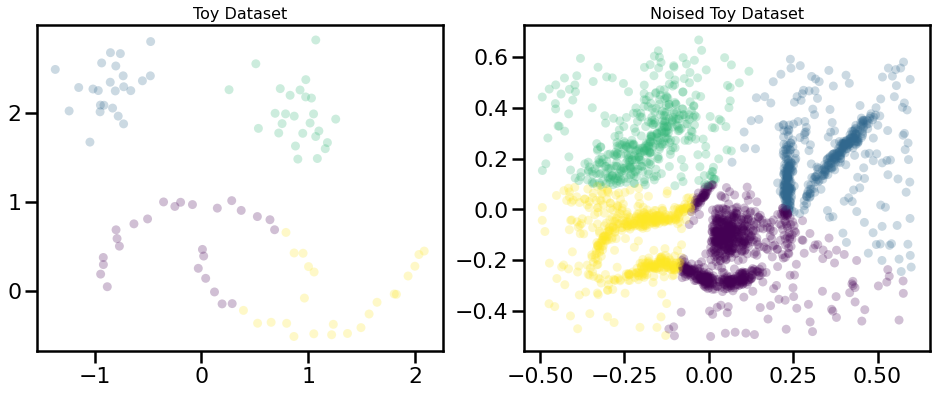

In [5]:
from sklearn.cluster import KMeans
kmeans_0 = KMeans(n_clusters=4, max_iter=200).fit(test_data_0)
kmeans_1 = KMeans(n_clusters=4, max_iter=200).fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=kmeans_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=kmeans_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

## Aglomerative Single Linkage clustering

Agglomerative clustering is a suite of algorithms all based on the same idea. The fundamental idea is that you start with each point in it's own cluster and then, for each cluster, use some criterion to choose another cluster to merge with. Do this repeatedly until you have only one cluster and you get get a hierarchy, or binary tree, of clusters branching down to the last layer which has a leaf for each point in the dataset. The most basic version of this, single linkage, chooses the closest cluster to merge, and hence the tree can be ranked by distance as to when clusters merged/split.

**Code your own Aglomerative Single Linkage clustering algorithm**!:

- Fill in the class 
- During the process, keep track of the cluster merges by saving a (num_samples-1,4) np.array being a linkage matrix in scypy format (to use their function to plot dendrogram: `scipy.cluster.hierarchy.dendrogram`). check documentation.

In [6]:
from copy import deepcopy


class my_SingleLinkageAglomerativeClustering():
    
    def __init__(self, metric="euclidean", n_clusters=3):
        '''
        Attributes:
        
        metric_: {"euclidean","precomputed"}
            the distance to be used
            if precomputed then X is distance matrix
        n_clusters: integer
            number of clusters to return 
        linkage_matrix_: (n-1, 4) np.array
            in the same format as linkage  
        labels_: integer np.array
            label assigment
        hierarchy_: list of np.array
            each array corresponds to label assigment
            at each level (number of clusters)
            hierarchy_[0]=np.array(list(range(n)))
        '''
        self.metric_ = metric
        self.n_clusters_ = n_clusters
        self.linkage_matrix_ = None
        self.labels_ = None
        self.hierarchy_ = None
        self.dict_clusters=None
        
    def fit(self, X):
        """ Create a hierarchy of clusters
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self: my_SingleLinkageAglomerativeClustering
            to have access to labels_
        """
        # if it's not precomputed compute the distance matrix
        # using from scipy.spatial import distance 
        
        # HINT:
        # You can use a minimum spanning tree and add merge in increasing order
        # or modifying the distance matrix 
        # (add row/column for new clusters and remove/put zero in old row/colums)
        
        # keep track of merges in linkage_matrix_ and labels in hierarchy_
        
        # update labels_ from the hierarchy level selected by n_clusters_ 
        
        n,p=X.shape
        if self.metric_=='euclidean' :
            m_dist_init = distance.cdist(X, X, 'euclidean')
        else : 
            m_dist_init=deepcopy(X)

        
        m_dist=deepcopy(m_dist_init)
        
        self.hierarchy_=[]
        self.hierarchy_.append(np.array(list(range(n))))
        
        # dict with the key is cluster number and the value is the list of matrix X components belonging to the cluster
        dict_clusters=dict(zip(range(0,n),[[k] for k in range(n)]))
        
        for k in range(n-1):
            
            ## get min 
            [i,j],min_=self.get_min_index(m_dist)
            
            ## add cluster to dict_clusters
            dict_clusters[len(dict_clusters)]=dict_clusters[i]+dict_clusters[j]
            dict_clusters[i],dict_clusters[j]=None,None
            
            ## Get the distance between last cluster and previous ones
            new_distances=self.get_min_distance(m_dist_init,dict_clusters)
            
            ## add column and row 
            m_dist=np.vstack((m_dist,new_distances[:-1]))
            m_dist=np.hstack((m_dist,new_distances.reshape(-1,1)))
            
            m_dist[i,:],m_dist[j,:],m_dist[:,i],m_dist[:,j]=0,0,0,0
            if self.linkage_matrix_ is None :
                self.linkage_matrix_=np.array([i,j,min_,len(dict_clusters[list(dict_clusters.keys())[-1]])])
            else :
                self.linkage_matrix_=np.vstack((self.linkage_matrix_,
                                           np.array([i,j,min_,len(dict_clusters[list(dict_clusters.keys())[-1]])])))

            ## add to self.hierarchy_
            copy_array=deepcopy(self.hierarchy_[-1])
            last_cluster=m_dist.shape[0]+1
            for t in dict_clusters[list(dict_clusters.keys())[-1]] : 
                copy_array[t]= last_cluster ## add last one 
            self.hierarchy_.append(copy_array)
        
        
        self.labels_=self.hierarchy_[-self.n_clusters_]
        self.dict_clusters=dict_clusters
        
        
    def get_min_index(self,m):
        """
        Function that gives the index of the minimum and the minimum ( different than 0) in m.
        """
        argmin=[0,0]
        min_=np.inf
        for i in range(m.shape[0]):
            for j in range(m.shape[1]):
                if m[i,j]<min_  and m[i,j]>0:
                    min_=m[i,j]
                    argmin=[i,j]
        return argmin,min_
    
    def get_min_distance(self,m_dist_init,dict_clusters):
        """
        Create an array that contains the min distances between the last formed cluster and the previous ones.
        """
        last_cluster=dict_clusters[list(dict_clusters.keys())[-1]]
        
        list_min_distances=[]
        for num_cluster in list(dict_clusters.keys()):
            if dict_clusters[num_cluster]==None :
                list_min_distances.append(0)
            else :
                local_distances=[]
                for element_last in last_cluster :
                    for element in dict_clusters[num_cluster] :
                        local_distances.append(m_dist_init[element][element_last])
                list_min_distances.append(min(local_distances))
        return np.array(list_min_distances)
                        
                

                
        
    def plot_dendrogram(self):
        '''Use self.linkage_matrix_ in `scipy.cluster.hierarchy.dendrogram` 
        to plot the dendrogram of the hierarchical structure
        '''     
        fig,ax=plt.subplots(figsize=(16, 6))
        ax.set_title('dendrogram for single linkage')
        dn = dendrogram(model.linkage_matrix_)

Apply the method to our toy datasets

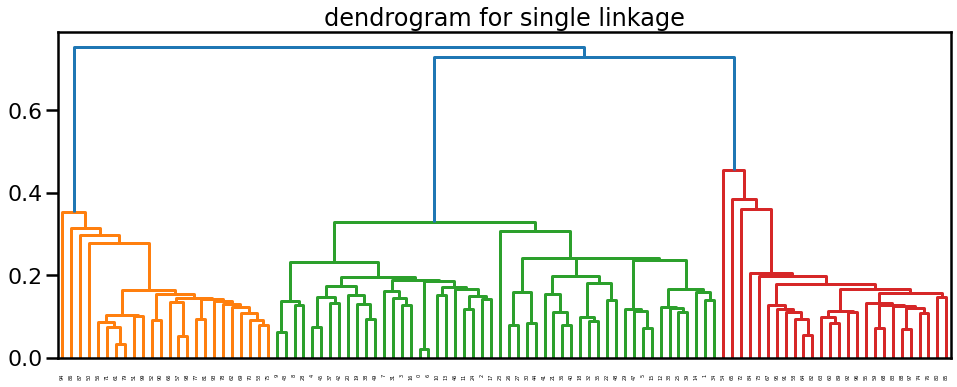

In [7]:
from scipy.spatial import distance 
from scipy.cluster.hierarchy import dendrogram,linkage

# TODO

model=my_SingleLinkageAglomerativeClustering()
model.fit(test_data_0)
model.plot_dendrogram()

Try the different linkage methods implemented in `sklearn`  and comment

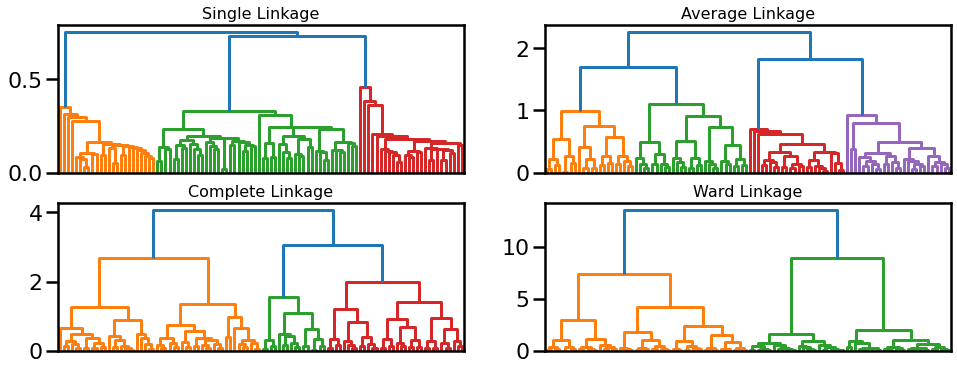

In [8]:
# Comparing dendrograms
fig, ax = plt.subplots(2, 2, figsize=(16, 6))

ax[0][0].set_title('Single Linkage', size=16)
ax[0][0].get_xaxis().set_visible(False)
Z = linkage(test_data_0, 'single')
dn = dendrogram(Z,ax=ax[0][0])

ax[1][0].set_title('Complete Linkage', size=16)
ax[1][0].get_xaxis().set_visible(False)
Z = linkage(test_data_0, 'complete')
dn = dendrogram(Z,ax=ax[1][0])

ax[0][1].set_title('Average Linkage', size=16)
ax[0][1].get_xaxis().set_visible(False)
Z = linkage(test_data_0, 'average')
dn = dendrogram(Z,ax=ax[0][1])

ax[1][1].set_title('Ward Linkage', size=16)
ax[1][1].get_xaxis().set_visible(False)
Z = linkage(test_data_0, 'ward')
dn = dendrogram(Z,ax=ax[1][1])

plt.show()


## Remarks : 
* We verify that we have the same dendrogram for the single linkage method.
* The single Linkage method seems the least efficient. In fact it gives not regular cluster sizes.
* The ward Linkage gives Clusters with regular sizes

## DBSCAN

DBSCAN is a density based algorithm -- it assumes clusters for dense regions. It is also the first actual clustering algorithm we've looked at: it doesn't require that every point be assigned to a cluster and hence doesn't partition the data, but instead extracts the 'dense' clusters and leaves sparse background classified as 'noise'. In practice DBSCAN is related to agglomerative clustering. As a first step DBSCAN transforms the space according to the density of the data: points in dense regions are left alone, while points in sparse regions are moved further away. Applying single linkage clustering to the transformed space results in a dendrogram, which we cut according to a distance parameter (called epsilon or `eps` in many implementations) to get clusters. Importantly any singleton clusters at that cut level are deemed to be 'noise' and left unclustered. 

Apply it to the test_data, how do you tune the parameters?

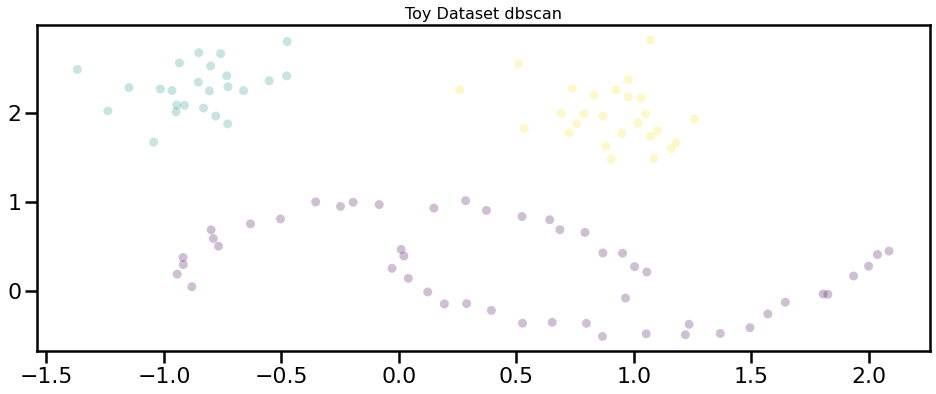

In [16]:
# TODO
#from sklearn.cluster import DBSCAN

dbscan = cluster.DBSCAN(eps=0.5, min_samples=5).fit(test_data_0)

fig, ax = plt.subplots(figsize=(16, 6))
ax.scatter(test_data_0.T[0], test_data_0.T[1], c=dbscan.labels_ , **plot_kwds)
ax.set_title('Toy Dataset dbscan', size=16)

plt.show()

## Answer : 

The parameters for DBSCAN are eps and minpts. For the latter, a big value gives highly dense clusters, containing few elements. A small minpts gives large clusters. The same for epsilon : if too small, the clusters will be highly dense. If too large , we will have probably one or two clusters. 
A heuristic to find the parameters :
* We choose minpts~2*dim(input_space). minpts=5 for our toy dataset. 
* We choose epsilon as the value corresponding to the of maximum curvature in the nearest neighbor distances plot (see next cell). We choose k=minpts.

Here we find epsilon=0.2 by the knn graph. But we may find a better value empirically (0.3 , 0.5 , it depends on the dataset). 

### Choose epsilon 

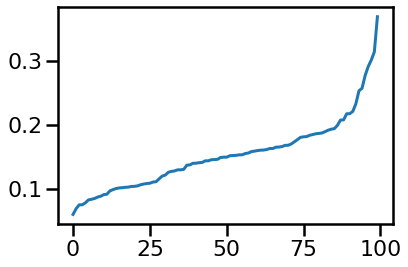

In [79]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(test_data_0)
distances0, _ = nbrs.kneighbors(test_data_0)

distances = np.sort(np.mean(distances0,axis=1))
plt.plot(distances)

## HDBSCAN

HDBSCAN is a recent algorithm developed by some of the same people who write the original DBSCAN paper. Their goal was to allow varying density clusters. The algorithm starts off much the same as DBSCAN: we transform the space according to density, exactly as DBSCAN does, and perform single linkage clustering on the transformed space. Instead of taking an epsilon value as a cut level for the dendrogram however, a different approach is taken: the dendrogram is condensed by viewing splits that result in a small number of points splitting off as points 'falling out of a cluster'. This results in a smaller tree with fewer clusters that 'lose points'. That tree can then be used to select the most stable or persistent clusters. This process allows the tree to be cut at varying height, picking our varying density clusters based on cluster stability.

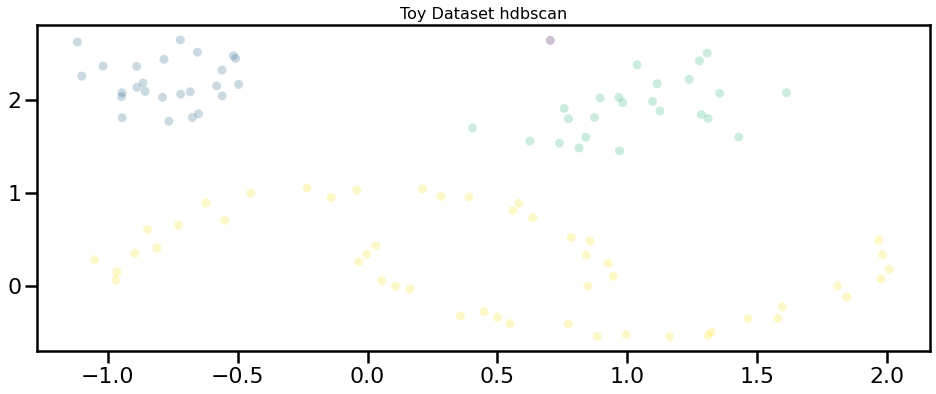

In [7]:
import hdbscan

hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
hdbscan_cluster.fit(test_data_0)

fig, ax = plt.subplots(figsize=(16, 6))
ax.scatter(test_data_0.T[0], test_data_0.T[1], c=hdbscan_cluster.labels_ , **plot_kwds)
ax.set_title('Toy Dataset hdbscan', size=16)

plt.show()


## Apply the algorithms to the following images and comment the results

### NASA Curiosity Picture

- Look at following NASA photo taken by a robot in mars:


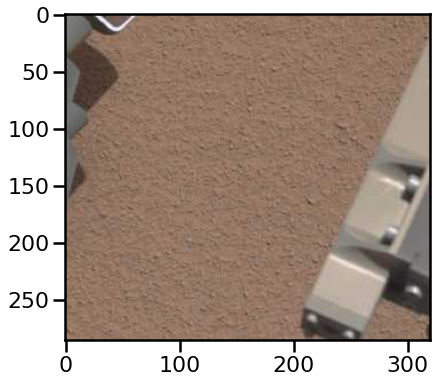

In [10]:
from PIL import Image

Im_1  = Image.open('im_nasa_reduced.jpg')

fig = plt.figure(figsize=(8, 6))
plt.imshow(Im_1)
plt.show()

- Transform the image to an intensity (I) and saturation (S) representation, it helps to distinguish bright and textures.

$$I=\frac{R+G+B}{3}$$
$$S=1-I\times min(R, G, B)$$

In [11]:
# TODO:

from matplotlib.image import imread

data = np.asarray(Im_1)
x,y,z=data.shape
flattened_data=data.reshape(-1,z)
I =(flattened_data[:,0]+flattened_data[:,1]+flattened_data[:,2])/3
S = 1- I * np.min(flattened_data,axis=1)

new_representation=np.array([[I[k],S[k]] for k in range(len(flattened_data))])

- Apply the seen algorithms to segment the image in the Intensity-Saturation representation, comment the results and check if you find something on mars' surface. Be careful with hdbscan and memory errors for some parameters choice (use algorithm='boruvka_kdtree').

"complete_cluster=cluster.AgglomerativeClustering(n_clusters=500,linkage='ward').fit(new_representation)\ncolors=[k/complete_cluster.labels_.max() for k in range(complete_cluster.labels_.max()+1)]\ncomplete_repr=np.array([colors[label] for label in complete_cluster.labels_])\nax4.imshow(complete_repr.reshape(x,y),cmap='gray')\n#ax1.scatter(new_representation.T[0], new_representation.T[1], c=hdbscan_cluster.labels_ , **plot_kwds)\nax4.set_title('Mars image complete linkage', size=16)"

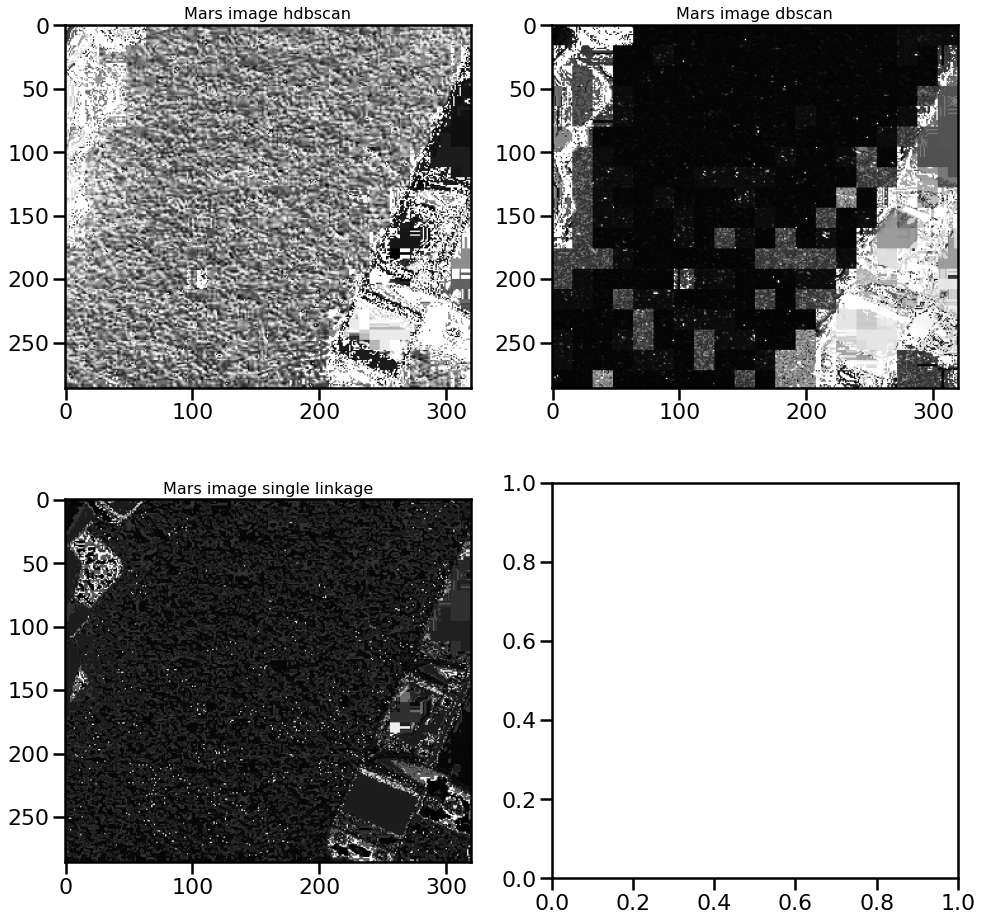

In [18]:
# TODO

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(16, 16))

hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=100, gen_min_span_tree=True , algorithm='boruvka_kdtree')
hdbscan_cluster.fit(new_representation)
colors=[k/hdbscan_cluster.labels_.max() for k in range(hdbscan_cluster.labels_.max()+1)]
hdbscan_repr=np.array([colors[label] for label in hdbscan_cluster.labels_])
ax1.imshow(hdbscan_repr.reshape(x,y),cmap='gray')
#ax1.scatter(new_representation.T[0], new_representation.T[1], c=hdbscan_cluster.labels_ , **plot_kwds)
ax1.set_title('Mars image hdbscan', size=16)

dbscan_cluster = cluster.DBSCAN(eps=0.1, min_samples=5).fit(new_representation)
colors=[k/dbscan_cluster.labels_.max() for k in range(dbscan_cluster.labels_.max()+1)]
dbscan_repr=np.array([colors[label] for label in dbscan_cluster.labels_])
ax2.imshow(dbscan_repr.reshape(x,y),cmap='gray')
ax2.set_title('Mars image dbscan', size=16)


single_cluster=cluster.AgglomerativeClustering(n_clusters=500,linkage='single').fit(new_representation)
colors=[k/single_cluster.labels_.max() for k in range(single_cluster.labels_.max()+1)]
single_repr=np.array([colors[label] for label in single_cluster.labels_])
ax3.imshow(single_repr.reshape(x,y),cmap='gray')
#ax1.scatter(new_representation.T[0], new_representation.T[1], c=hdbscan_cluster.labels_ , **plot_kwds)
ax3.set_title('Mars image single linkage', size=16)

"""complete_cluster=cluster.AgglomerativeClustering(n_clusters=500,linkage='ward').fit(new_representation)
colors=[k/complete_cluster.labels_.max() for k in range(complete_cluster.labels_.max()+1)]
complete_repr=np.array([colors[label] for label in complete_cluster.labels_])
ax4.imshow(complete_repr.reshape(x,y),cmap='gray')
#ax1.scatter(new_representation.T[0], new_representation.T[1], c=hdbscan_cluster.labels_ , **plot_kwds)
ax4.set_title('Mars image complete linkage', size=16)"""

## Remarks 

* Implementing another agglomerative clustering method ( with another linkage such as ward, complete ...) results in memory problems. So I didn't do it here. 
* The method used here to illustrate pixels represented in the Intensity/Saturation representation is to associate to each cluster a grayscale color. Suppose we have n clusters, we give to the first one the representation in the 1/n ( close to black ) , the second 2/n , etc ...  The problem of this method is that may associate different colors to clusters that are close in the euclidean space. 
* Nevertheless, we can notice some particular texture patterns with the dbscan and single linkage methods. For the former, the patterns are wider. These differences can be solved with an appropriate fintuning of the dbscan paramters.
* We had only noise for the hdbscan clustering. It may due to the choice of the algorithm, the value of min_cluster_size parameter ...

### Color compression

One interesting application of clustering is in color compression within images. 
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

Get a simplified 10-colored version of the following image by applying k-means. Plot both images.

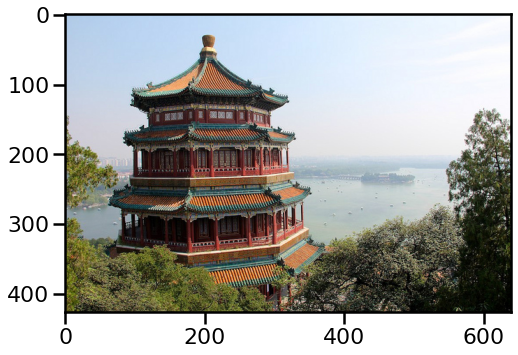

In [18]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")

fig = plt.figure(figsize=(8, 6))
plt.imshow(china);

In [19]:
# TODO

ncolors=10
array=np.asarray(china)
normalized_array=array/255
x,y,z=array.shape
flattened_array=normalized_array.reshape(-1,z)

## Apply K means
kmeans_china = KMeans(n_clusters=ncolors).fit(flattened_array)

## We replace each pixel RGB encodings by the centroid coordinates of the cluster that it belongs to. 

new_china=np.array([kmeans_china.cluster_centers_[label] for label in kmeans_china.labels_])
new_china_img=new_china.reshape((x,y,-1))



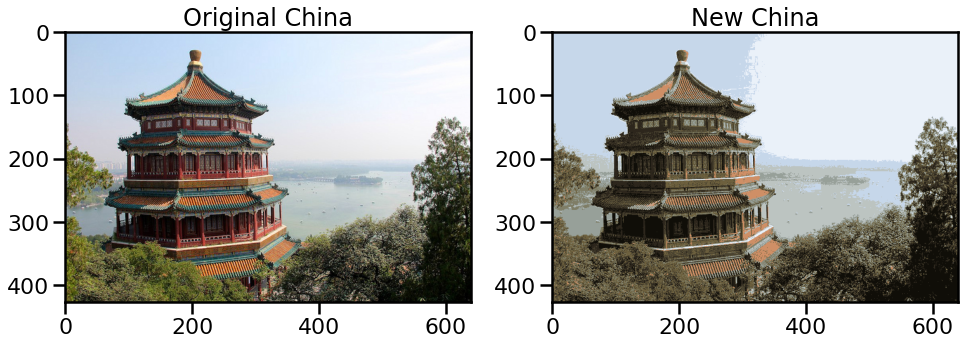

In [20]:
## Plots 

fig,ax= plt.subplots(1,2,figsize=(16, 12))
ax[0].set_title('Original China')
ax[0].imshow(china)

ax[1].set_title('New China')
ax[1].imshow(new_china_img)

The global color pattern of the image is well preserved.